In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import catboost
from sklearn.preprocessing import PolynomialFeatures

In [2]:
!pip install -q flaml

In [3]:
!pip install -q lofo-importance

In [4]:
from sklearn.model_selection import KFold
# from feature_selection_lofo import lofo
from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance
from sklearn.metrics import make_scorer, mean_squared_log_error

/opt/conda/lib/python3.10/site-packages/lofo/lofo_importance.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [35]:
train_df = pd.read_csv('/kaggle/input/fsdfsdg123/train.csv').drop(columns=['id'])
test_df = pd.read_csv('/kaggle/input/fsdfsdg123/test.csv')
test_id = test_df.id
test_df = test_df.drop(columns=['id'])

train_df

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,prepared_food,florist,cost
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,62.09
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,0.0,121.80
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,0.0,83.51
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,0.0,66.78
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,1.0,111.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360331,7.60,4.0,5.0,5.0,3.0,13.50,1.0,0.0,33.0,30268.0,0.0,0.0,0.0,0.0,0.0,133.42
360332,14.44,4.0,4.0,0.0,4.0,18.80,1.0,1.0,18.0,20319.0,0.0,0.0,0.0,0.0,0.0,81.85
360333,10.74,3.0,0.0,0.0,2.0,11.30,1.0,0.0,35.0,30584.0,1.0,1.0,1.0,1.0,1.0,87.07
360334,11.04,3.0,1.0,0.0,3.0,10.20,0.0,1.0,14.0,30584.0,1.0,1.0,1.0,1.0,1.0,146.72


In [6]:
from catboost.utils import get_gpu_device_count

gpu_count = get_gpu_device_count()
if gpu_count > 0:
    print(f"Доступно {gpu_count} GPU(ов)")
else:
    print("GPU не доступен")

Доступно 2 GPU(ов)


In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [8]:
noise = np.random.normal(0, 0.01, train_df.shape)
train_df = train_df + noise

In [9]:
smooth_factor = 0.05
train_df.cost = train_df.cost * (1 - smooth_factor) + smooth_factor * np.mean(train_df.cost)
train_df.cost

0          63.948149
1         120.676093
2          84.324933
3          68.418548
4         110.913546
             ...    
360331    131.733942
360332     82.735770
360333     87.694752
360334    144.388001
360335    121.324803
Name: cost, Length: 360336, dtype: float64

In [11]:
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

dataset = Dataset(
    df=train_df.sample(frac=0.2, random_state=1),
    target="cost",
    features=[col for col in train_df.columns if col != "cost" and col != "salad_bar"]
)

# model
cat = CatBoostRegressor(random_state=0, task_type='GPU', verbose=1000, devices='0', thread_count=2, gpu_ram_part=0.9)

# define the validation scheme and scorer. The default model is LightGBM
lofo_imp = LOFOImportance(dataset, cv=cv, scoring=scorer, model=cat)

# get the mean and standard deviation of the importances in pandas format
importance_df = lofo_imp.get_importance()

Learning rate set to 0.069772
0:	learn: 28.3988812	total: 150ms	remaining: 2m 29s
999:	learn: 25.6483946	total: 2.59s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3846884	total: 3.23ms	remaining: 3.23s
999:	learn: 25.6725460	total: 2.23s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3997705	total: 3.55ms	remaining: 3.55s
999:	learn: 25.6825769	total: 2.33s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3929467	total: 3.56ms	remaining: 3.56s
999:	learn: 25.6617769	total: 2.3s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3821647	total: 2.99ms	remaining: 2.99s
999:	learn: 25.6458614	total: 2.22s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.4162455	total: 3.11ms	remaining: 3.11s
999:	learn: 25.7208682	total: 2.28s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3933604	total: 3ms	remaining: 3s
999:	learn: 25.6888483	total: 2.28s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3903699	total: 3.75ms	remaining: 

  0%|          | 0/14 [00:00<?, ?it/s]

Learning rate set to 0.069772
0:	learn: 28.3988812	total: 3.02ms	remaining: 3.01s
999:	learn: 25.7028850	total: 2.29s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3850143	total: 2.94ms	remaining: 2.93s
999:	learn: 25.6968654	total: 2.21s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3997705	total: 3.74ms	remaining: 3.73s
999:	learn: 25.7404608	total: 2.21s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3825069	total: 3.28ms	remaining: 3.28s
999:	learn: 25.7252640	total: 2.21s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3823211	total: 3.31ms	remaining: 3.3s
999:	learn: 25.7009330	total: 2.44s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.4162455	total: 2.95ms	remaining: 2.95s
999:	learn: 25.7512448	total: 2.23s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3933604	total: 2.96ms	remaining: 2.96s
999:	learn: 25.7299203	total: 2.23s	remaining: 0us
Learning rate set to 0.069772
0:	learn: 28.3903699	total: 2.94ms	remai

In [15]:
importance_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4,val_imp_5,val_imp_6,val_imp_7,val_imp_8,val_imp_9
6,store_sqft,0.004533,0.000311,0.004250,0.004597,0.004488,0.005089,0.004551,0.003943,0.004803,0.004678,0.004220,0.004714
1,avg_cars_at home(approx).1,0.001070,0.000207,0.001179,0.000687,0.001076,0.001379,0.000927,0.001240,0.001281,0.000852,0.000911,0.001163
12,total_children,0.001011,0.000164,0.000665,0.000987,0.001049,0.001108,0.000997,0.001196,0.001303,0.000901,0.000974,0.000930
10,num_children_at_home,0.000439,0.000119,0.000437,0.000303,0.000558,0.000483,0.000324,0.000581,0.000472,0.000472,0.000199,0.000558
5,florist,0.000157,0.000205,0.000193,-0.000107,0.000643,0.000209,-0.000068,0.000255,0.000010,0.000096,0.000056,0.000279
4,coffee_bar,0.000095,0.000190,-0.000062,0.000055,0.000437,0.000084,-0.000183,0.000123,-0.000071,0.000006,0.000153,0.000412
7,prepared_food,0.000083,0.000168,-0.000199,0.000215,0.000127,0.000176,-0.000188,0.000087,0.000223,-0.000037,0.000077,0.000345
0,units_per_case,0.000006,0.000207,-0.000146,-0.000142,0.000077,0.000168,-0.000142,0.000190,0.000192,-0.000285,-0.000216,0.000364
11,video_store,0.000005,0.000252,0.000147,-0.000146,0.000396,0.000222,-0.000310,0.000044,0.000344,-0.000342,-0.000213,-0.000091
3,low_fat,-0.000038,0.000186,0.000099,0.000022,0.000225,-0.000299,-0.000193,0.000267,-0.000012,-0.000275,-0.000073,-0.000138


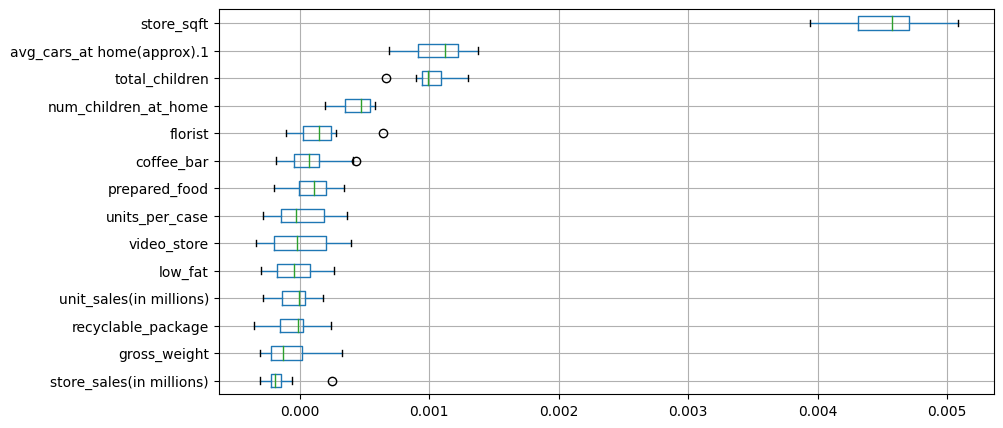

In [13]:
plot_importance(importance_df, figsize=(10, 5), kind="box")

In [16]:
selected_features = importance_df.feature[:9].to_numpy()

In [17]:
X_df, y = train_df.loc[:, selected_features], train_df.loc[:, "cost"].values

In [18]:
scaler = StandardScaler()
X_df = scaler.fit_transform(X_df)

In [19]:
def custom_metric(
    X_val, y_val, estimator, labels,
    X_train, y_train, weight_val=None, weight_train=None,
    *args,
):
    from sklearn.metrics import mean_squared_error
    import time

    start = time.time()
    y_pred = estimator.predict(X_val)
    pred_time = (time.time() - start) / len(X_val)
    val_loss = mean_squared_error(y_val, y_pred, sample_weight=weight_val)
    y_pred = estimator.predict(X_train)
    train_loss = mean_squared_error(y_train, y_pred, sample_weight=weight_train)
    alpha = 0.5
    return val_loss * (1 + alpha) - alpha * train_loss, {
        "val_loss": val_loss,
        "train_loss": train_loss,
        "pred_time": pred_time,
    }

In [20]:
from flaml.automl.automl import AutoML

settings = {
    "time_budget": 60, # time to spend to find the best model, in seconds
    "metric": custom_metric,
    "task": 'regression',
    "seed": 1,
    "verbose": 3,
    "estimator_list": ["lgbm", "xgboost", "catboost"]
}

automl = AutoML()
automl.fit(X_df, y, **settings)

[flaml.automl.logger: 12-17 14:34:38] {1728} INFO - task = regression
[flaml.automl.logger: 12-17 14:34:38] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-17 14:34:38] {1838} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 12-17 14:34:38] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'catboost']
[flaml.automl.logger: 12-17 14:34:38] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-17 14:34:38] {2393} INFO - Estimated sufficient time budget=20026s. Estimated necessary time budget=35s.
[flaml.automl.logger: 12-17 14:34:38] {2442} INFO -  at 0.2s,	estimator lgbm's best error=805.8240,	best estimator lgbm's best error=805.8240
[flaml.automl.logger: 12-17 14:34:38] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-17 14:34:38] {2442} INFO -  at 0.2s,	estimator lgbm's best error=795.9149,	best estimator lgbm's best error=795.9149
[flaml.automl.logger: 12-17 14:34:38] {2258} INFO -

In [21]:
automl.best_config, automl.best_estimator

({'n_estimators': 25,
  'num_leaves': 145,
  'min_child_samples': 43,
  'learning_rate': 0.11748230662604456,
  'log_max_bin': 9,
  'colsample_bytree': 0.7347641455499587,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 47.079742074423415},
 'lgbm')

In [26]:
# poly_features = poly.transform(test_df.loc[:, selected_features])
# test_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(test_df.loc[:, selected_features].columns))

# test_df = scaler.fit_transform(test_df)

In [36]:
test_df = scaler.fit_transform(test_df.loc[:, selected_features])

In [38]:
pseudo_labels = automl.predict(test_df)
pseudo_train = pd.concat([pd.DataFrame(X_df), pd.DataFrame(test_df)], axis=0)
pseudo_labels = np.concatenate([y, pseudo_labels])

In [39]:
cat_model = CatBoostRegressor(
    iterations=10_000,
    learning_rate=0.05,
    l2_leaf_reg=10,  # L2-регуляризация
    bagging_temperature=1.0,  # Случайность выборки
    random_strength=2.0,  # Случайный шум
    depth=8,  # Глубина деревьев
    min_data_in_leaf=10,  # Минимум объектов в листе
    verbose=200,
    random_state=42,
    task_type='GPU',
    devices='0'
)
cat_model.fit(pseudo_train, pseudo_labels)

0:	learn: 22.5059316	total: 13.9ms	remaining: 2m 18s
200:	learn: 21.0003819	total: 1.71s	remaining: 1m 23s
400:	learn: 20.8503296	total: 3.29s	remaining: 1m 18s
600:	learn: 20.7410802	total: 4.86s	remaining: 1m 15s
800:	learn: 20.6488733	total: 6.45s	remaining: 1m 14s
1000:	learn: 20.5646968	total: 8.03s	remaining: 1m 12s
1200:	learn: 20.4837338	total: 9.6s	remaining: 1m 10s
1400:	learn: 20.4088855	total: 11.2s	remaining: 1m 8s
1600:	learn: 20.3351563	total: 12.8s	remaining: 1m 6s
1800:	learn: 20.2652485	total: 14.4s	remaining: 1m 5s
2000:	learn: 20.1963698	total: 15.9s	remaining: 1m 3s
2200:	learn: 20.1315839	total: 17.5s	remaining: 1m 1s
2400:	learn: 20.0677811	total: 19.1s	remaining: 1m
2600:	learn: 20.0019481	total: 20.6s	remaining: 58.7s
2800:	learn: 19.9406325	total: 22.2s	remaining: 57s
3000:	learn: 19.8798020	total: 23.7s	remaining: 55.4s
3200:	learn: 19.8215040	total: 25.3s	remaining: 53.8s
3400:	learn: 19.7627395	total: 26.9s	remaining: 52.2s
3600:	learn: 19.7063604	total: 28

In [40]:
predicts = cat_model.predict(test_df)

In [41]:
ids = test_id.to_numpy()

data = {
    'id': list(ids),
    'cost': list(predicts)
}

pd.DataFrame(data).to_csv('automl+filter+pseudo.csv', index=False)

In [42]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

In [50]:
xgb_regressor = XGBRegressor(**{'tree_method'        : 'hist',
                      'device'             : 'cuda',
                      'objective'          : 'reg:squarederror',
                      'random_state'       : 42,
                      'colsample_bytree'   : 0.7,
                      'learning_rate'      : 0.07,
                      'max_depth'          : 6,
                      'n_estimators'       : 3500,                         
                      'reg_alpha'          : 0.025,
                      'reg_lambda'         : 1.75,
                      'min_child_weight'   : 1000
    
})
catboost_regressor = CatBoostRegressor(**{
                   'task_type'           : "GPU",
                   'objective'           : "RMSE",
                   'eval_metric'         : "RMSE",
                   'bagging_temperature' : 0.5,
                   'iterations'          : 3500,
                   'learning_rate'       : 0.065,
                   'od_wait'             : 25,
                   'max_depth'           : 7,
                   'l2_leaf_reg'         : 1.5,
                   'min_data_in_leaf'    : 1000,
                   'random_strength'     : 0.65, 
                   'verbose'             : 0
                   
})
lgbm_regressor = LGBMRegressor(**{
                "objective": "mse",
                "n_estimators": 3500,
                "num_leaves": 256,
                "subsample": 0.6,
                "colsample_bytree": 0.8,
                "learning_rate": 0.00871,
                'max_depth': 11,
                "n_jobs": 4,
                "device": "gpu",
                "verbosity": -1,
                "importance_type": "gain",
})

# Create a Voting Regressor
voting_regressor = VotingRegressor(estimators=[
    ('xgb', xgb_regressor),
    ('catboost', catboost_regressor),
    ('lgbm', lgbm_regressor)
], n_jobs=-1, verbose=True)

In [46]:
# stacking_regressor = StackingRegressor(estimators=[
#     ('xgb', xgb_regressor),
#     ('lgbm', lgbm_regressor)
# ], n_jobs=-1, verbose=True, final_estimator=catboost_regressor)
# stacking_regressor.fit(pseudo_train, pseudo_labels)

In [52]:
voting_regressor.fit(pseudo_train, pseudo_labels)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=0.7, device='cuda',
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          n_estimators=3500, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('catboost',
                             <catboost.core.CatBoostRegressor object at 0x7e0c76a5eef0>),
                            ('lgbm',
                             LGBMRegressor(colsample_bytree=0.8, device='gpu',
                                           importance_type='gain',
                                           learning_rate=0.00871, max_depth=11,
                                           n_estimators=3500, n_jobs=4,
                                           num_leaves=256, objective='mse',
                                           subsample=0.6, verbosity=-1))],
                n_jobs=-1, verbose=True)

In [ ]:
preds = voting_regressor.predict(pseudo_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:55:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[Voting] ...................... (1 of 3) Processing xgb, total=  53.1s
[Voting] ..................... (3 of 3) Processing lgbm, total= 3.8min
[Voting] ................. (2 of 3) Processing catboost, total= 2.6min


In [ ]:
ids = test_id.to_numpy()

data = {
    'id': list(ids),
    'cost': list(preds)
}

pd.DataFrame(data).to_csv('auto+voting+features.csv', index=False)